# Module 10 - Regression Algorithms - Linear Regression

Welcome to Machine Learning (ML) in Python!

We're going to use a dataset about vehicles and their respective miles per gallon (mpg) to explore the relationships between variables.

The first thing to be familiar with is the data preprocessing workflow. Data needs to be prepared in order for us to successfully use it in ML. This is where a lot of the actual work is going to take place!

I'm going to use this dataset for each of the regression algorithms, so we can see how each one differs.

The next notebooks with the dataset will be:

- Linear Regression w/ Transformed Target (Logarithmic)
- Ridge Regression with Standardized Inputs
- Ridge and LASSO Regression with Polynomial Features

These four notebooks are designed to be a part of a series, with this one being the first.

We're going to start by importing our usual packages and then some IPython settings to get more output:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Part A: Data Exploration

The first thing to do is import and explore our mpg dataset!

There's a few things to note in the dataset description: na values are denoted by `?` and column names are in a separate doc.

I added the column names so we don't have to worry about them:

In [2]:
loc = "https://raw.githubusercontent.com/mhall-simon/python/main/data/car-mpg/auto-mpg.data"

df = pd.read_csv(loc, sep="\s+", header=None, na_values="?")

cols = {0:"mpg", 1:"cylinders", 2:"displacement", 3:"horsepower", 4:"weight", 5:"accel", 6:"year", 7:"origin", 8:"model"}
df = df.rename(columns=cols)

df.head(15)

,mpg,cylinders,displacement,horsepower,weight,accel,year,origin,model
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
5,15.0,8,429.0,198.0,4341.0,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220.0,4354.0,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215.0,4312.0,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225.0,4425.0,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190.0,3850.0,8.5,70,1,amc ambassador dpl


When starting, it's always good to have a look at how complete our data set is.

Let's see just how many na values were brought into the dataset per column:

In [3]:
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
accel           0
year            0
origin          0
model           0
dtype: int64

We have 6 missing values for horsepower!

A safe assumption for imputing missing values is to insert the column mean, let's do that! (Feature engineering is somewhere that we can go into this more in depth.)

*Note:* Imputing values is something that's not always objective, as it introduces some biases. We could also drop those 6 rows out of our dataset, however, I think imputing average hp isn't too serious of an issue.

In [4]:
df = df.replace(np.nan, df.horsepower.mean())
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
accel           0
year            0
origin          0
model           0
dtype: int64

Now, there's no more missing values!

Let's get some descriptive statistics running for our numerical columns (non-numerical are automatically dropped):

In [5]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,accel,year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.199187,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,95.000000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


Another thing we can look at is the number of unique car models in the dataset:

In [6]:
df.nunique(axis=0)

mpg             129
cylinders         5
displacement     82
horsepower       94
weight          351
accel            95
year             13
origin            3
model           305
dtype: int64

For the ML analysis, there's too many models to worry about, so we're going to have them drop off the dataset! We're trying to predict mpg, and with our data the model name will have practically no predictive power!

One Hot Encoding the makes/models would make the dataset have almost more columns than rows!

In [7]:
df = df.drop("model", axis=1)
df.head()

,mpg,cylinders,displacement,horsepower,weight,accel,year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Train-Test Split

We're getting closer to starting our analysis! The first major consideration is the train/test split, where we reserve a chunk of our dataset to validate the model.

Remember, no peeking into the results with testing to train our model! That'll introduce a bias!

Let's separate our data into X and y, and then run the split:

In [8]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=97)

Another important thing to look at is the distributions of continuous variables and their pairwise relationships.

Seaborn has a really cool pairplot function that allows us to easily visualize this automatically! We just need to pass in columns of continuous variables.

Note: This is a marginal dependence, and does not keep all other variables fixed! We should only analyze this after our split!

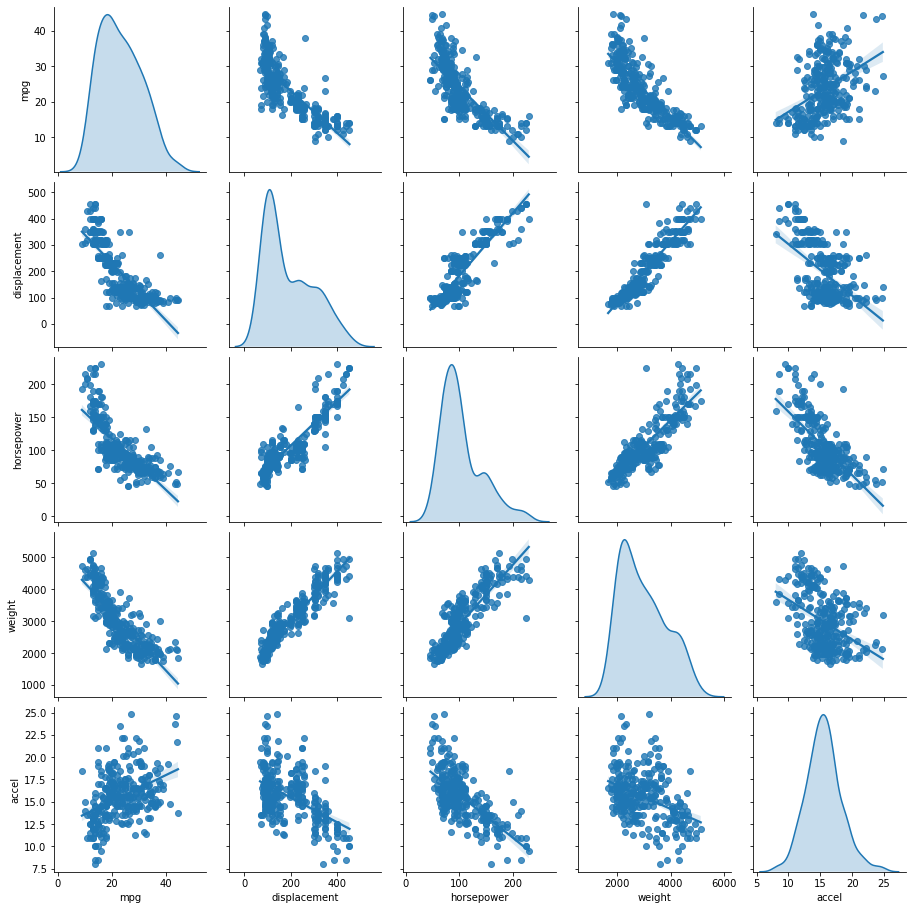

In [10]:
train_dataset = X_train.copy()
train_dataset.insert(0, "mpg", y_train)

sns.pairplot(train_dataset[['mpg','displacement','horsepower','weight','accel']], kind='reg', diag_kind='kde')

When looking at this, there's two things to takeaway:

1. `mpg` is close to being normal, but there's a long tail. This means we may be better taking the log of mpg when running our analysis - something to explore in the next notebook.

2. Some relationships are not quite linear! We will work on this more in the following notebooks!

Let's now get into the ML aspects!

## Part B: Data Preprocessing & Pipeline

There's a lot of online tutorials that show the SKLearn models and how to call them in one line, and not much else.

A really powerful tool is to leverage the pipelines, as you can adjsut easily on the fly and not rewrite too much code!

Pipelines also reduce the potential for errors, as we only define preprocessing steps, and don't actually need to manipulate our tables. When we transform the target with a log later, we also don't need to worry about switching between log and normal values! It'll be handled for us.

It's also not as bad as it seems!

The first main step is to separate our data into:

- categorical columns that need to be one-hot encoded
- continuous columns (no changes - for now)
- other processing subsets (none in these examples, but binary columns would be handled a bit differently.)
 - label encoding the response (y) variable when we get into classification models

Let's get right to it! We can split apart the explanatory column names into the two categories with basic lists:

In [11]:
categorical_columns = ['cylinders','origin','year']
numerical_columns = ['displacement','horsepower','weight','accel']

*Discussion:* Why is Year Categorical, even though it's a numerical year?

In Linear Regression, the year 70 (1970) would appear to be a factor of 80 (1980) by about 9/10ths, and it would be scaled that way. This would not make sense, as we expect only marginal increases in mpg year-over-year. To prevent a relationship like this, we're going to one-hot encode the years into categories.

Now, let's put together our preprocessing pipeline.

We'll need to:

1. OneHot Encode Categorical
2. Leave Continuous Alone

Let's build our preprocessor:

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

preprocessor = make_column_transformer((OneHotEncoder(drop="first"), categorical_columns), remainder="passthrough")

Why are we dropping the first category in each categorical column?

Our regression can imply the first one with zeros for all the encoded variables, and by not including it we are preventing colinearity from being introduced!

A potential issue that can arise is when you encounter new labels in the test/validation sets that are not one-hot encoded. Right now, this would toss an error if it happens! Later notebooks will go into how to handle these errors.

Now, let's build the pipeline:

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

model = make_pipeline(preprocessor, LinearRegression())

And now we can easily train our model and preprocess our data all in one step:

In [14]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['cylinders', 'origin',
                                                   'year'])])),
                ('linearregression', LinearRegression())])

Before we start evaluating the model, I'll show you some useful features with the pipeline:

1. View Named Steps

In [15]:
model.named_steps

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                  ['cylinders', 'origin', 'year'])]),
 'linearregression': LinearRegression()}

2. View Coefficients and Intercept (Expanded Later)

In [16]:
model.named_steps['linearregression'].coef_

array([ 7.00229252e+00,  4.55346150e+00,  4.62593535e+00,  6.67825310e+00,
        1.97627763e+00,  2.19432071e+00,  1.40536862e+00, -3.67421887e-01,
       -7.13664249e-02,  1.76992196e+00,  1.07634788e+00,  2.09369469e+00,
        3.69145814e+00,  2.79598409e+00,  5.48332236e+00,  9.17863442e+00,
        7.23503156e+00,  8.15271105e+00,  8.30008925e-03, -2.72661560e-02,
       -5.16012492e-03,  2.47534687e-03])

In [17]:
model.named_steps['linearregression'].intercept_

29.696115914387285

3. Generate Predictions

*Viewing First 10*

In [18]:
model.predict(X_train)[:10]

array([17.87259223, 24.47705171, 12.42683577, 24.60563056, 26.81606671,
       28.27228319, 18.91208693, 27.58545186, 28.10898852, 35.82476973])

## Part C: Evaluating Machine Learning Model

So, now we have an ML model, but how do we know if it's good?

Also, what's our criteria for good?

This changes depending upon what you're doing!

Let's bring in some metrics, and look at our "in sample" performance. This is the performance valuation in sample, without looking at any test data yet!

- $r^2$: coefficient of determination
- mean absolute error
- mean squared error

Let's generate our in-sample predictions based upon the model:

In [19]:
y_pred_in = model.predict(X_train)

And now let's generate some metrics:

This compares the training (truth) values, to the ones predicted by the line of best fit.

In [20]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2_score(y_train, y_pred_in)
mean_squared_error(y_train, y_pred_in)
mean_absolute_error(y_train, y_pred_in)

0.875960310591527

7.418612966494767

2.091549203323859

We're explaining about 87.5% of the variation in our in-sample dataset! That's pretty good, but will it hold when analyzing out of sample?

Also, we now know that our average absolute error is 2.09 mpg! That's not too bad, considering the range of the dataset and STD from the data:

In [21]:
y_train.std()
y_train.max() - y_train.min()

7.746596396016497

35.6

Let's now visualize our predictions! As a note, we want all of our datapoints to be along the line!

*Tip:* If you're reproducing this graph, ensure that the diagonal goes through the origin of the plot. The red line is setup to draw from corner to corner, and if you move your axes this may not work out!

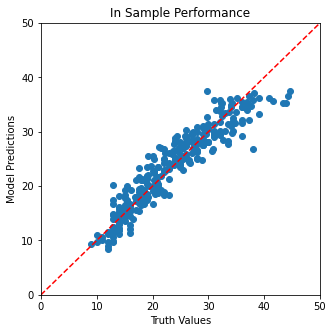

In [22]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_train, y_pred_in)
ax.plot([0,1],[0,1], transform=ax.transAxes, ls="--", c="red")
plt.xlim([0,50])
plt.ylim([0,50])
plt.ylabel("Model Predictions")
plt.xlabel("Truth Values")
plt.title("In Sample Performance")
plt.show();

Our predictions are pretty good!

A few things to note:

- It's a really good fit, but it appears that there's a slight curve to this dataset.
- This is still in sample (we trained the model on this data)
- If we're making predictions, what regions are we confident in?

I think average mpg we'll be accurate, however, at the edges we're missing some of the trend.

Let's plot our residual error to see the shape:

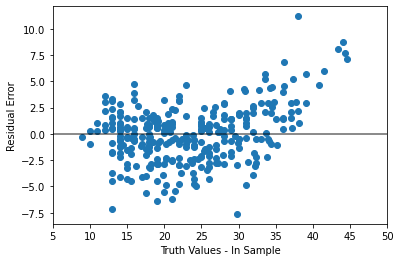

In [23]:
plt.scatter(y_train, y_train-y_pred_in)
plt.xlabel("Truth Values - In Sample")
plt.ylabel("Residual Error")
plt.xlim([5,50])
plt.plot([5,50],[0,0], color='black', alpha=0.6)
plt.show();

Our errors definitely have curvature in them! We'll improve upon this in the next module!

For now...

Let's start looking at the coefficients in our model while it's simple.

We can grab coefficients out of the preprocessor to ensure that the coefficients line up with labels.

It'll always be in order of the preprocessor, so we can first fetch the feature names from the one hot encoded, and then just concatenate our numerical columns as there were no changes!

In [24]:
feature_names = (model.named_steps['columntransformer']
                 .named_transformers_['onehotencoder']
                 .get_feature_names(input_features=categorical_columns))

feature_names = np.concatenate([feature_names, numerical_columns])

coefs = pd.DataFrame(
    model.named_steps['linearregression'].coef_,
    columns=['Coefficients'],
    index=feature_names
)

coefs

,Coefficients
cylinders_4,7.002293
cylinders_5,4.553462
cylinders_6,4.625935
cylinders_8,6.678253
origin_2,1.976278
origin_3,2.194321
year_71,1.405369
year_72,-0.367422
year_73,-0.071366
year_74,1.769922


Let's plot the coefficients to see if there's anything we can learn out of it!

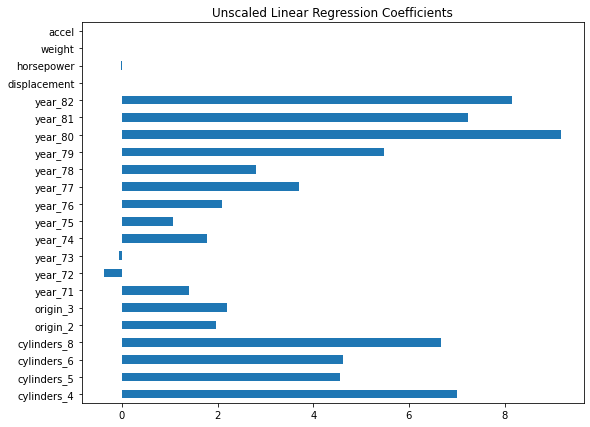

In [25]:
coefs.Coefficients.plot(kind='barh', figsize=(9,7))
plt.title("Unscaled Linear Regression Coefficients")
plt.show();

Woah, it looks like weight in unimportant at first glance, even though it would probably impact mpg quite a bit!

A word of caution! We just can't compare the coefficients, as they're in a different scale!

If we scale them with their standard deviation, then we can compare them. However, some meaning is lost!

Currently, the coefficient `-0.034440` for `horsepower` means that while holding all else equal, increasing the horsepower by 1 unit decreases mpg by about 0.034 mpg!

So, if we add 100 hp to the car, mileage decreases by about 3.4 mpg if we hold all else equal!

Let's scale these coefficients to compare them better! Just keep in mind that the 1hp:-0.34mpg relationship will no longer be interpretable from the scaled coefficients. But, we will be able to compare between coefficients.

Using the model pipeline, we can easily transform our data using the built in transformer, and then take the std:

`model.named_steps['columntransformer'].transform(DATASET)` is how we can use the transformer we built above.

When training the model, this dataset transformation happened all behind the scenes!! However, we can reproduce it with our training sample to work with it manually:

**NOTE:** The pipeline transformation is better than manual, because we know for certain the order of the columns that are being outputted. We fetched them above! The preprocessor in this instance returned a SciPy sparse matrix, which we can import with a new DataFrame constructor:

In [26]:
X_train_preprocessed = pd.DataFrame.sparse.from_spmatrix(
    model.named_steps['columntransformer'].transform(X_train),
    columns=feature_names
)

X_train_preprocessed.head(10)

,cylinders_4,cylinders_5,cylinders_6,cylinders_8,origin_2,origin_3,year_71,year_72,year_73,year_74,year_75,year_76,year_77,year_78,year_79,year_80,year_81,year_82,displacement,horsepower,weight,accel
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225.0,95.0,3264.0,16.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,350.0,105.0,3725.0,19.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,351.0,158.0,4363.0,13.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,90.0,2430.0,14.5
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,262.0,85.0,3015.0,17.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,98.0,83.0,2075.0,15.9
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,225.0,100.0,3233.0,15.4
7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.0,83.0,2219.0,16.5
8,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,116.0,81.0,2220.0,16.9
9,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,91.0,68.0,1970.0,17.6


By plotting the standard deviations, we can see for certain that the coeffs are definitely in a different scale!

Weight varies in the thousands, while acceleration is usually around 10-20 seconds!!

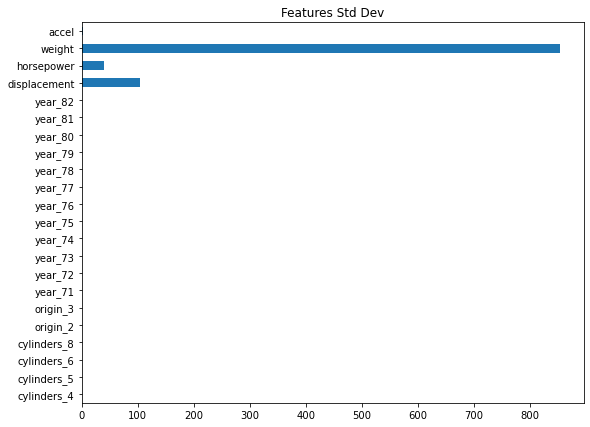

In [27]:
X_train_preprocessed.std(axis=0).plot(kind='barh', figsize=(9,7))
plt.title("Features Std Dev")
plt.show();

As you can probably see, the standard deviation of weight is far higher than any other variable!

This makes it impossible to compare.

Now, let's scale everything.

This scale works because very large continuous variables have a large standard deviation, but very small coefficients, which brings them down. The opposite is true for very small continuous variables for standard deviations, their coefficient is usually much larger. By multiplying the two together, we're bringing everything in towrads the middle, and with the same units of measurement.

In [28]:
coefs['coefScaled'] = coefs.Coefficients * X_train_preprocessed.std(axis=0)
coefs

,Coefficients,coefScaled
cylinders_4,7.002293,3.506957
cylinders_5,4.553462,0.372406
cylinders_6,4.625935,1.934446
cylinders_8,6.678253,2.903084
origin_2,1.976278,0.767973
origin_3,2.194321,0.875868
year_71,1.405369,0.343940
year_72,-0.367422,-0.094195
year_73,-0.071366,-0.021510
year_74,1.769922,0.473149


Now, let's plot the scaled coefs:

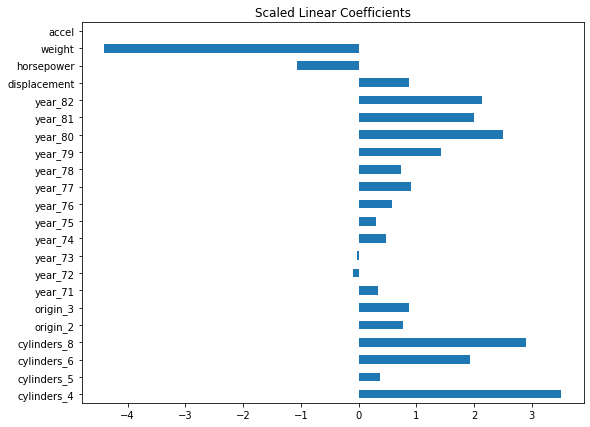

In [29]:
coefs.coefScaled.plot(kind="barh", figsize=(9,7))
plt.title("Scaled Linear Coefficients")
plt.show();

Earlier, weight had almost no impact on the model at first glance! Now, we can see that it's the most important explanatory variable for mpg.

Let's now do our final validations for the model by bringing in the test data!!

The first is going to be done using the test (reserved) dataset, which we can make predictions with easily:

In [30]:
y_pred_out = model.predict(X_test)

And now let's generate a small DataFrame to compare metrics from in sample and out of sample!

Out of sample performance is usually worse, it's usually a question of how much!

In [31]:
metrics = pd.DataFrame(index=['r2','mse','mae'],columns=['in','out'])

metrics['in'] = (r2_score(y_train, y_pred_in), mean_squared_error(y_train, y_pred_in), mean_absolute_error(y_train, y_pred_in))
metrics['out'] = (r2_score(y_test, y_pred_out), mean_squared_error(y_test, y_pred_out), mean_absolute_error(y_test, y_pred_out))

metrics

,in,out
r2,0.875960,0.854859
mse,7.418613,9.325976
mae,2.091549,2.207213


When looking at the data, we see that the $r^2$ value decreased slightly from 0.875 to 0.854! This is still fairly significant!

And let's do a similar graph for out of sample performance:

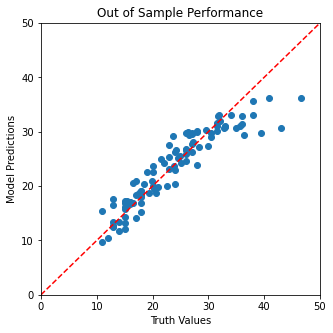

In [32]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_test, y_pred_out)
ax.plot([0,1],[0,1], transform=ax.transAxes, ls="--", c="red")
plt.xlim([0,50])
plt.ylim([0,50])
plt.ylabel("Model Predictions")
plt.xlabel("Truth Values")
plt.title("Out of Sample Performance")
plt.show();

We're doing pretty good! There's stil some curvature that we'll work on fixing in the next notebooks.

Let's plot our residuals one more time:

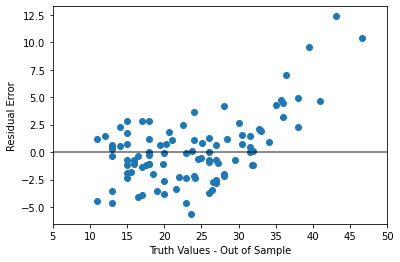

In [33]:
plt.scatter(y_test, y_test-y_pred_out)
plt.xlabel("Truth Values - Out of Sample")
plt.ylabel("Residual Error")
plt.xlim([5,50])
plt.plot([5,50],[0,0], color='black', alpha=0.6)
plt.show();

Our model is pretty good, except for when we go above 32-ish mpg. Our model is predicting values far too high.

We'll solve this in a later notebook.

Another key question for ML is...

How do we know if the performance is due to just our sample selected? How much would our model change depending upon the sample selected?

We can solve for this using cross validation!

Cross validation takes different samples from our dataset, runs the regression, and then outputs the results!

We can easily cut the dataset into chunks and see how it behaves.

We're going to plot the distributions of coefficients throughout the folds to see how stable the model is:

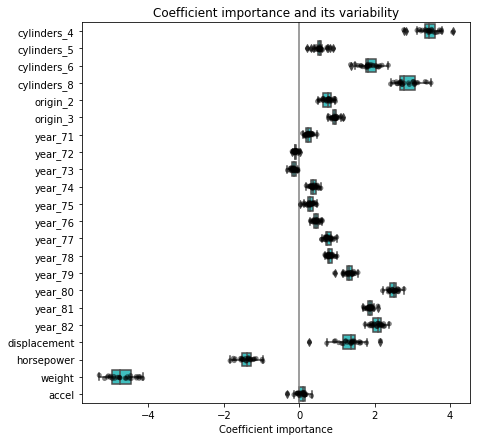

In [36]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

# Part 1: Defining Cross Validation Model
cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)

# Part 2: Analyzing Each Model's Coefficients, and Setting Them In DataFrame:
cv_coefs = pd.DataFrame(
    [est.named_steps['linearregression'].coef_ * X_train_preprocessed.std(axis=0) for est in cv_model['estimator']],
    columns=feature_names
)

# Part 3: Plotting the Distribution of Coefficients
plt.figure(figsize=(9,7))
sns.stripplot(data=cv_coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=cv_coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)
plt.show();

What are the takeaways from this plot?

Our model doesn't appear to be too sensitive to the splits in training and testing!

This is a signal that our model is robust, and we should have confidence that our findings weren't due to choosing a "good" sample!

If we saw a variable changing from -6 to +2, that would be a sign it is not stable!

Now, we're ready to start exploring the second notebook! Which starts working towards a fix in the curvature!

## Bonus Box: Easily Checking for Variable Colinearity

If we suspect two variables are colinear, we can easily check for it with the following code:

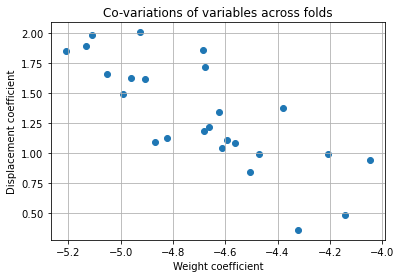

In [35]:
plt.scatter(cv_coefs['weight'], cv_coefs['displacement'])
plt.ylabel('Displacement coefficient')
plt.xlabel('Weight coefficient')
plt.grid(True)
plt.title('Co-variations of variables across folds');

These are not colinear across folds, which is good for the model!

If they *were* colinear across folds, it would look something like this:

<div>
<img src=https://github.com/mhall-simon/python/blob/main/data/screenshots/Screen%20Shot%202021-03-22%20at%206.38.12%20PM.png?raw=True width="400"/>
</div>

If you notice strong colinearlity, then one should be removed and you can run the model again!